# 載入套件

In [1]:
import numpy as np
import pandas as pd
import librosa
import torch.nn as nn
import torch
import os 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
import torch
import transformers
from transformers import AutoFeatureExtractor,AutoModelForAudioClassification,TrainingArguments, Trainer
import datasets 
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift
import numpy as np
import random

/home/samuel/.conda/envs/aicup/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True  
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"

# 資料路徑設定

In [3]:
medical_file_name = './data/training datalist.csv'
accoustic_folder="./data/training_voice_data/"

# 載入訓練資料

In [4]:
# 讀取訓練資料集表單
source_df = pd.read_csv(medical_file_name)
print("source_df.shape :", source_df.shape)
print("source_df.columns :", source_df.columns)

source_df.shape : (1000, 28)
source_df.columns : Index(['ID', 'Sex', 'Age', 'Disease category', 'Narrow pitch range',
       'Decreased volume', 'Fatigue', 'Dryness', 'Lumping', 'heartburn',
       'Choking', 'Eye dryness', 'PND', 'Smoking', 'PPD', 'Drinking',
       'frequency', 'Diurnal pattern', 'Onset of dysphonia ', 'Noise at work',
       'Occupational vocal demand', 'Diabetes', 'Hypertension', 'CAD',
       'Head and Neck Cancer', 'Head injury', 'CVA',
       'Voice handicap index - 10'],
      dtype='object')


# 資料前處理

In [5]:
# 挑選出要訓練的Disease category 1、2、3
source_df = source_df.loc[source_df['Disease category'].isin([1, 2, 3,4, 5]), ['ID', 'Disease category']]

# 在dataframe中加入要訓練的音檔路徑
source_df['wav_path'] = source_df['ID'].map(lambda x :f"{accoustic_folder}{x}.wav")
source_df['Disease category'] = source_df['Disease category']-1 
print("Disease category in source_df :", source_df['Disease category'].unique())
print("source_df :\n", source_df)

Disease category in source_df : [0 1 2 4 3]
source_df :
           ID  Disease category                                wav_path
0    1202f15                 0  ./data/training_voice_data/1202f15.wav
1    0600ve0                 1  ./data/training_voice_data/0600ve0.wav
2    1001o7l                 1  ./data/training_voice_data/1001o7l.wav
3    1201c1t                 0  ./data/training_voice_data/1201c1t.wav
4    0402jvt                 0  ./data/training_voice_data/0402jvt.wav
..       ...               ...                                     ...
995  0G00ftn                 2  ./data/training_voice_data/0G00ftn.wav
996  1201pkr                 3  ./data/training_voice_data/1201pkr.wav
997  0202p64                 2  ./data/training_voice_data/0202p64.wav
998  12021au                 1  ./data/training_voice_data/12021au.wav
999  04027it                 1  ./data/training_voice_data/04027it.wav

[1000 rows x 3 columns]


In [6]:
res={"audio":[],"class":[]}
for i,row in source_df.iterrows():
    voice = librosa.load(row['wav_path'], sr=16000, offset=0)[0]
    res["audio"].append(voice)
    res["class"].append(row['Disease category'])

## 訓練與驗證資料切分
* 確保training data與testing data個類別的比例相同
* 將training data分為兩部分first half與second half，前者用在first stage 訓練，後者用在second stage訓練

In [7]:
df = pd.DataFrame(res)
train_df = pd.DataFrame()
test_df = pd.DataFrame()
for i in range(0,5):
    len_1=len(df[df['class']==i])
    train_df = pd.concat([train_df,df[df['class']==i].iloc[:int(len_1/6*5),:]])
    test_df = pd.concat([test_df,df[df['class']==i].iloc[int(len_1/6*5):,:]])

In [8]:
train_df_first_half = pd.DataFrame()
for i in range(0,5):
    len_1=len(train_df[train_df['class']==i])
    train_df_first_half = pd.concat([train_df_first_half,train_df[train_df['class']==i].iloc[:int(len_1/2),:]])

In [9]:
test_df['class'].value_counts()

class
0    90
1    37
2    28
3     8
4     6
Name: count, dtype: int64

In [10]:
train_df_first_half['class'].value_counts()

class
0    223
1     91
2     70
3     18
4     13
Name: count, dtype: int64

In [11]:
train_df = train_df_first_half.sample(frac=1).reset_index(drop=True) #只取training前半段
test_df = test_df.sample(frac=1).reset_index(drop=True)

### 轉換成huggingface dataset

In [12]:
train_dataset = datasets.Dataset.from_pandas(train_df)
test_dataset = datasets.Dataset.from_pandas(test_df)
all_dataset = datasets.DatasetDict()
all_dataset['train'] = train_dataset
all_dataset['test'] = test_dataset

# 訓練聲學特徵

### voice data transform
* data augmentation
* 將 voice data經wave2vec feature extractor轉換

In [13]:
feature_extractor= AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")
augment = Compose([
    # AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5), 
])

def train_transform(examples):

    audio_arrays = np.array(examples["audio"],np.float32)
    augmented_samples = augment(samples=audio_arrays, sample_rate=16000)
    augmented_samples = augmented_samples.squeeze()
    inputs = feature_extractor(
        augmented_samples, sampling_rate=feature_extractor.sampling_rate, max_length=32000, truncation=True
    )
    inputs['label'] = examples['class']
    return inputs
def val_transform(examples):

    audio_arrays = np.array(examples["audio"],np.float32)
    audio_arrays = audio_arrays.squeeze()
    inputs = feature_extractor(
        audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=32000, truncation=True
    )
    inputs['label'] = examples['class']
    return inputs

/home/samuel/.conda/envs/aicup/lib/python3.8/site-packages/transformers/configuration_utils.py:379: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [14]:
all_dataset['train'].set_transform(train_transform)
all_dataset['test'].set_transform(val_transform)

## 建模型並訓練

### Baseline

In [15]:
(train_df['class']==0).sum()/len(train_df)

0.5373493975903615

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
num_labels = 5
model = AutoModelForAudioClassification.from_pretrained("facebook/wav2vec2-base",num_labels=num_labels)
model  = model.to(device)

Some weights of the model checkpoint at facebook/wav2vec2-base were not used when initializing Wav2Vec2ForSequenceClassification: ['project_q.weight', 'project_hid.bias', 'quantizer.weight_proj.weight', 'project_hid.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'project_q.bias']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['projector.weight', 'classifier.bias', 'projector.

In [17]:
import evaluate
accuracy = evaluate.load("accuracy")
def mean_recall(predictions,references):
    results_recall = recall_score(references, predictions, average=None).mean()
    return results_recall
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    res = accuracy.compute(predictions=predictions, references=eval_pred.label_ids)
    res['recall'] = mean_recall(predictions,eval_pred.label_ids)
    return res

training_args = TrainingArguments(
    output_dir="accoustic_model",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    gradient_accumulation_steps=1,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    warmup_ratio=0.1,
    remove_unused_columns=False,
    load_best_model_at_end=True,
    # eval_delay=5,
    metric_for_best_model="recall",
    save_total_limit=5
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=all_dataset['train'],
    eval_dataset=all_dataset['test'],
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,

)

In [18]:
res = trainer.train()

/home/samuel/.conda/envs/aicup/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Recall
1,1.525400,1.431845,0.532544,0.200000
2,1.282200,1.232547,0.532544,0.200000
3,1.202500,1.164234,0.568047,0.247778
4,1.165800,1.155887,0.597633,0.283492
5,1.157800,1.165949,0.556213,0.228571
6,1.128800,1.158051,0.585799,0.264286
7,1.129900,1.153439,0.579882,0.257143
8,1.104900,1.063250,0.591716,0.281270
9,1.088600,1.150517,0.597633,0.298254
10,1.092500,1.037574,0.633136,0.375251


In [19]:
best_model_path = trainer.state.best_model_checkpoint
best_model_path

'accoustic_model/checkpoint-1924'

In [21]:
l = []
train_loss={}
for obj in trainer.state.log_history:
    if "eval_loss" in obj.keys():
        l.append(obj)
    if "loss" in obj.keys():
        train_loss['loss'] = train_loss.get("loss",[])
        train_loss['loss'].append(obj['loss'])

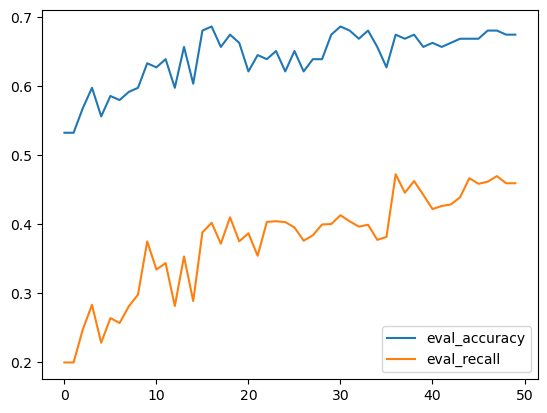

In [28]:
dic = {}
for d in l:
    for k,v in d.items():
        dic[k] = dic.get(k,[])
        dic[k].append(v)
eval_df = pd.DataFrame(dic)
ax = eval_df.iloc[:,1:3].plot()

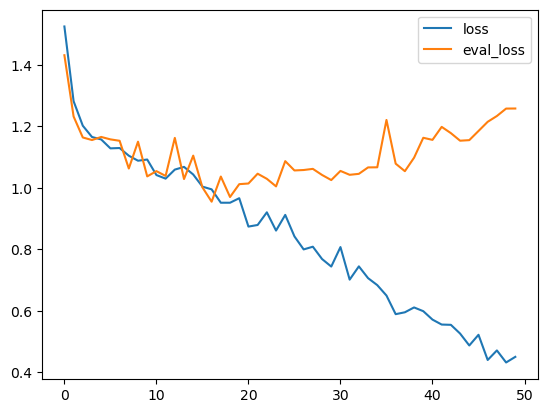

In [23]:
df_train = pd.DataFrame(train_loss)
df = pd.concat([df_train,eval_df.iloc[:,0]],axis=1)
ax = df.plot()

## 訓練資料預測結果

Training UAR(Unweighted Average Recall) : 0.6531471717121942


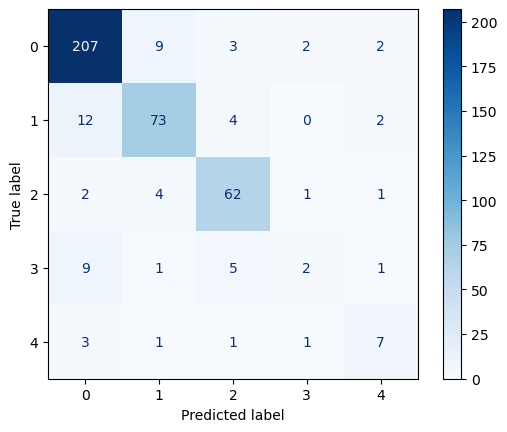

In [24]:
y_true = train_df['class'] 
y_pred = []
feature_extractor = AutoFeatureExtractor.from_pretrained(best_model_path)
model = AutoModelForAudioClassification.from_pretrained(best_model_path)
for i in range(len(train_df)):
    voice = train_df.iloc[i,:]['audio']
    inputs = feature_extractor(voice, sampling_rate=16000, return_tensors="pt")
    logits = model(**inputs).logits[0]
    pred = np.argmax(logits.detach().cpu().numpy())
    y_pred.append(pred)

results_recall = recall_score(y_true, y_pred, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

# 驗證資料測試結果

Training UAR(Unweighted Average Recall) : 0.4724195624195625


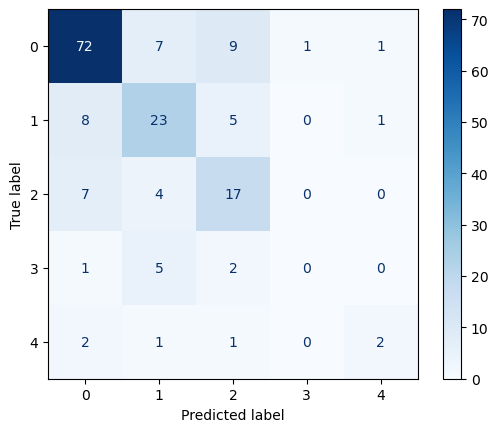

In [25]:
y_true = test_df['class'] 
y_pred = []
feature_extractor = AutoFeatureExtractor.from_pretrained(best_model_path)
model = AutoModelForAudioClassification.from_pretrained(best_model_path)
for i in range(len(test_df)):
    voice = test_df.iloc[i,:]['audio']
    inputs = feature_extractor(voice, sampling_rate=16000,max_length=48000, return_tensors="pt")
    logits = model(**inputs).logits[0]
    pred = np.argmax(logits.detach().cpu().numpy())
    y_pred.append(pred)
results_recall = recall_score(y_true, y_pred, average=None)
print("Training UAR(Unweighted Average Recall) :", results_recall.mean())

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot(cmap='Blues')

In [27]:
with open("accoustic_model_path.txt","w") as f :
    f.write(best_model_path)